In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
import pandas as pd

2023-08-29 11:16:19.953917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TRAIN_DATA_PATH = tf.keras.utils.get_file(
    'ratings_train.txt',
    'https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_train.txt'
)
TEST_DATA_PATH = tf.keras.utils.get_file(
    'ratings_test.txt',
    'https://github.com/ironmanciti/NLP_lecture/raw/master/data/naver_movie/ratings_test.txt'
)

In [3]:
train_data = pd.read_csv(TRAIN_DATA_PATH, delimiter='\t')
test_data = pd.read_csv(TEST_DATA_PATH, delimiter='\t')

train_data.shape, test_data.shape

((150000, 3), (50000, 3))

In [4]:
train_data = train_data.dropna().sample(n=15_000, random_state=42)
test_data = test_data.dropna().sample(n=5_000, random_state=42)

train_data.shape, test_data.shape

((15000, 3), (5000, 3))

In [5]:
train_data

,id,document,label
128076,7865795,원본이 최고,1
65517,5417631,스릴감과 훈훈함이 있는 영화.,1
85048,8357466,굉장히 저평가되는 영화중 하나라고 생각함,1
118192,8252946,정말영화같은이야기 영화여서 영화같은이야기가 좋다,1
92368,7800452,계기도없는데 이상하다,0
...,...,...,...
66369,4996977,스릴러의 교과서라고 할 수 있다.,1
70213,8708989,아주 예전에 본 영화! 흥미진진하다!,1
71937,7476401,마이너스 만개의 별을 ...시간만 늘리는 발연기들 이제~~~ 그만~~~,0
39180,5920328,잔인하다,1


In [6]:
class_names = {1: 'positive', 0: 'negative'}

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_data['document'], train_data['label'])
).batch(batch_size).shuffle(10_000).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_data['document'], test_data['label'])
).batch(batch_size).shuffle(10_000).cache().prefetch(buffer_size=AUTOTUNE)

2023-08-29 11:16:28.222809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6638 MB memory:  -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [8]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(6):
        print(f'review: {text_batch.numpy()[i].decode("utf-8")}')
        label = label_batch.numpy()[i]
        print(f'label: {label} ({class_names[label]})')

review: ㅋㅋ지ㅓ밓다크크크크굿작ㅇㅋㅋㅋ
label: 1 (positive)
review: 진정 현실적인 조폭영화의 결말!!
label: 1 (positive)
review: 아 퇴폐적이고 어두운분위기의 영화
label: 0 (negative)
review: 잘 싸웠기에 내일도 행복할거야!
label: 1 (positive)
review: 두 호모새끼의 발연기에 화가난다..국어책 읽냐?
label: 0 (negative)
review: 더워서 공포영화를 봤건만 더 짜증나네요 재미없어
label: 0 (negative)


2023-08-29 11:16:28.553248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'

map_model_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_model_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [10]:
bert_prerocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_prerocess_model

In [11]:
test_text = ['지금까지 극장에서 본 영화 중에 제일 재미있었음.']
text_preprocessed = bert_prerocess_model(test_text)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {list(text_preprocessed["input_word_ids"].shape)}')
print(f'Word Ids   : {list(text_preprocessed["input_word_ids"])}')
print(f'Input Mask : {list(text_preprocessed["input_mask"])}')
print(f'Type Ids   : {list(text_preprocessed["input_type_ids"])}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : [1, 128]
Word Ids   : [<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([   101,   9706,  40032,  18382,   8925,  96006,   9358,  42428,
       102246,   9672,  18392,   9659,  22458, 119192, 119138,  32158,
          119,    102,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
  

In [12]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_model

In [13]:
bert_results = bert_model(text_preprocessed)
print(bert_results['pooled_output'].shape)
print(bert_results['pooled_output'][0, :10])
print(bert_results['sequence_output'].shape)
print(len(bert_results['encoder_outputs']))

(1, 768)
tf.Tensor(
[ 0.28347224 -0.04790231  0.21491405  0.01787294 -0.07537768  0.34203243
  0.0990389   0.26426762 -0.31700712  0.24709632], shape=(10,), dtype=float32)
(1, 128, 768)
12


In [14]:
def build_classifier():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_input = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    output = encoder(encoder_input)
    net = output['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [15]:
test_text

['지금까지 극장에서 본 영화 중에 제일 재미있었음.']

In [16]:
classifier = build_classifier()
bert_raw_result = classifier(tf.constant(test_text))

bert_raw_result, tf.sigmoid(bert_raw_result)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05750778]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.514373]], dtype=float32)>)

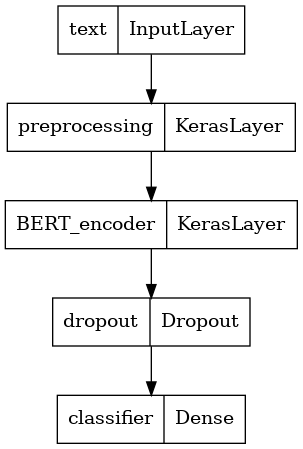

In [17]:
tf.keras.utils.plot_model(classifier)

In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [19]:
len(train_ds)

938

In [20]:
epochs = 5
steps_per_epoch = len(train_ds)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr = init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)
classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)
classifier

In [21]:
import time

s = time.time()
history = classifier.fit(x=train_ds, validation_data=test_ds, epochs=epochs)
print((time.time() - s) / 60)

Epoch 1/5
938/938 [==============================] - 347s 351ms/step - loss: 0.5382 - binary_accuracy: 0.7129 - val_loss: 0.4322 - val_binary_accuracy: 0.7810
Epoch 2/5
938/938 [==============================] - 328s 349ms/step - loss: 0.3622 - binary_accuracy: 0.8393 - val_loss: 0.4857 - val_binary_accuracy: 0.7984
Epoch 3/5
938/938 [==============================] - 328s 350ms/step - loss: 0.2578 - binary_accuracy: 0.8984 - val_loss: 0.5739 - val_binary_accuracy: 0.8182
Epoch 4/5
938/938 [==============================] - 328s 350ms/step - loss: 0.1981 - binary_accuracy: 0.9344 - val_loss: 0.7007 - val_binary_accuracy: 0.8232
Epoch 5/5
938/938 [==============================] - 327s 349ms/step - loss: 0.1464 - binary_accuracy: 0.9529 - val_loss: 0.7925 - val_binary_accuracy: 0.8250
27.641288443406424


In [23]:
loss, accuracy = classifier.evaluate(test_ds)
loss, accuracy


313/313 [==============================] - 33s 106ms/step - loss: 0.7925 - binary_accuracy: 0.8250


(0.792549729347229, 0.824999988079071)

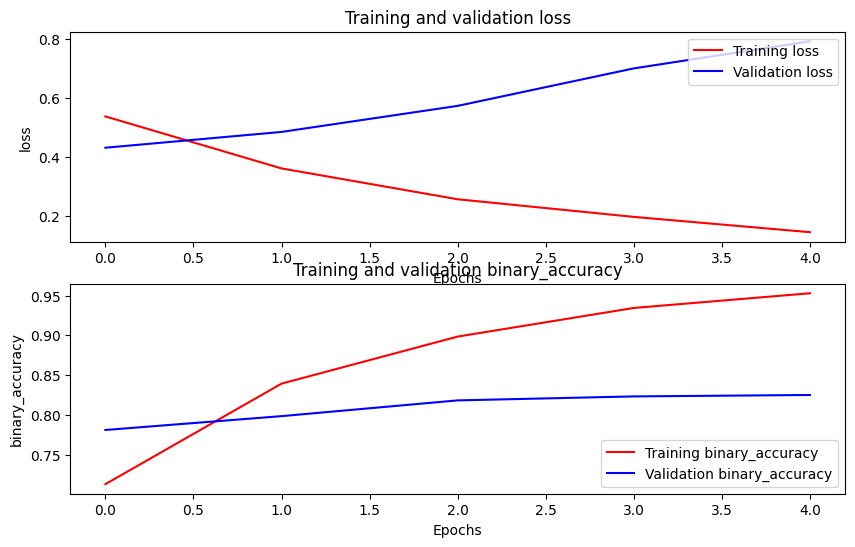

In [25]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

for i, metric in enumerate(['loss', 'binary_accuracy']):
    plt.subplot(2, 1, i+1)
    plt.plot(history.history[metric], 'r', label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], 'b', label=f'Validation {metric}')
    plt.title(f'Training and validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(loc='upper right' if metric == 'loss' else 'lower right')

In [26]:
dataset_name = 'kor_movie'
model_path = f'data/{dataset_name}_bert'
classifier.save(model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: data/kor_movie_bert/assets


INFO:tensorflow:Assets written to: data/kor_movie_bert/assets


In [27]:
loaded_model = tf.saved_model.load(model_path)
loaded_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f0867aa3040>

In [28]:
def inference(inputs, results):
    result_for_printing = [
        f'input: {inputs[i]:<30}, score: {results[i][0]:.6f}' for i in range(len(inputs))
    ]
    print(*result_for_printing, sep='\n')
    print()

In [29]:
examples = [
    test_text[0],
    '이것은 놀라운 영화입니다!',  
    '영화는 너무 훌륭했다!',
    '영화는 밋밋했다.',
    '영화는 재미있었다.',
    '영화는 끔찍했다...'
]
loaded_results = tf.sigmoid(loaded_model(tf.constant(examples)))
inference(examples, loaded_results)

input: 지금까지 극장에서 본 영화 중에 제일 재미있었음.   , score: 0.998043
input: 이것은 놀라운 영화입니다!                , score: 0.997593
input: 영화는 너무 훌륭했다!                  , score: 0.997903
input: 영화는 밋밋했다.                     , score: 0.001928
input: 영화는 재미있었다.                    , score: 0.997551
input: 영화는 끔찍했다...                   , score: 0.001982

